## Macuject ML Challenge Task

The task is to fit a model to the provided data as closely as possible.

There are 2 datasets provided, a train and a validation set.
Train a model on the train data, and measure its performance on the validation data. The final 'Y' column is the target variable.

For the model training, use either PyTorch or Keras (any version).
For your model, use a standard type of neural net.

Measure its performance using the MAE (mean absolute error).
A reasonably good perforance would be *MAE < 0.006*.

Put your solution in a notebook in a repo in a Github account of your own (if you dont have an account you'll have to create own), and provide us a link to the repo. In your notebook show clearly the MAE you attain.

Some example 'skeleton' code is provided below (in PyTorch) to help you start (if you're using Keras, thats fine, but you'll have to provide equivalent code in Keras).

Please develop/ modify this as you wish, and provide the missing parts to complete model training/ evaluation. For example-
- a model 
- an optimizer, loss function, etc ...
- any other elements to 
    - process/ pre-process data
    - understand, optimise the data, model performance, etc

Show your output and results, and comment on them.

Please indicate how much time you spent on this (this is only for our own purposes in adjusting the test).


In [18]:
import os
import torch
from torch.utils.data import Dataset, DataLoader


In [19]:
# load data
import pandas as pd
train_data=pd.read_csv('train_data.csv').values
val_data=pd.read_csv('validation_data.csv').values
train_inp = train_data[:,0:-1]
train_targets = train_data[:,-1]
val_inp = val_data[:,0:-1]
val_targets = val_data[:,-1]
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [20]:
torch.backends.cudnn.benchmark = True
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)


In [21]:
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        # self.transform=transforms.Compose([transforms.Normalize([0.5], [0.5])])
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(targets).float()
        
    def __getitem__(self, index):
        x = self.data[index].reshape(-1)
        # x = self.transform(x)
        y = self.targets[index].reshape(-1)
        return x, y
    
    def __len__(self):
        return len(self.data)

In [22]:
train_loader = DataLoader(CustomDataset(train_inp,train_targets), batch_size=25)
val_loader = DataLoader(CustomDataset(val_inp,val_targets), batch_size=25)


In [23]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(6,1200,bias=True),nn.ReLU(inplace=True))
        self.fc2 = nn.Sequential(nn.Linear(1200,1200,bias=True),nn.ReLU(inplace=True))
        self.fc3 = nn.Sequential(nn.Linear(1200,1200,bias=True),nn.ReLU(inplace=True))
        self.fc4 = nn.Sequential(nn.Linear(1200,1))
    def forward(self,x):
        h = self.fc1(x)
        h = self.fc2(h)
        h = self.fc3(h)
        h = self.fc4(h)
        return h
model = Net().to(device)

In [24]:
# 3. Define neural network cost funtion, optimizer, learning rate and number of epoch
import torch.optim as optim
learning_rate=0.0001
criterion = nn.L1Loss(reduction="sum") # Define a loss function. For classification problem we use binary cross-entropy loss
# optimizer = optim.RAdam(model.parameters(), lr=learning_rate)#, momentum=0.9) # Define the optimizer and learning rate. We use stochastic gradient descent optimizer with a learning rate
import torch_optimizer as optim # pip install torch-optimizer
optimizer = optim.RAdam(model.parameters(),lr=learning_rate)

In [25]:
n_epochs = 400

train_losses = []
val_losses = []
least_MAE=float('inf')
for epoch in range(n_epochs):
    print(f'epoch:{epoch}/{n_epochs}')
    train_loss = 0.0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data,target=data.to(device),target.to(device)
        output = model(data)
        loss = criterion(target,output)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
    M_Loss = train_loss / len(train_loader.dataset)
    train_losses.append(M_Loss)
    print('Train error: {:.6f}'.format(M_Loss))
    model.eval()
    AE = 0
    with torch.no_grad():
        for data, target in val_loader:
            data,target=data.to(device),target.to(device)
            output = model(data)
            AE += torch.sum(torch.abs(target - output)).item()
    MAE = AE / len(val_loader.dataset)
    val_losses.append(MAE)
    if MAE<least_MAE:
        least_MAE = MAE
        torch.save(model.state_dict(),'params.pth')
    print('Val error: {:.6f}'.format(MAE))
print('----------Training completed-----------')
print(f'Best MAE:{least_MAE}')

epoch:0/400
Train error: 0.036035
Val error: 0.033041
epoch:1/400
Train error: 0.029250
Val error: 0.027198
epoch:2/400
Train error: 0.024272
Val error: 0.021404
epoch:3/400
Train error: 0.019024
Val error: 0.014299
epoch:4/400
Train error: 0.016468
Val error: 0.016159
epoch:5/400
Train error: 0.013297
Val error: 0.013964
epoch:6/400
Train error: 0.012314
Val error: 0.011195
epoch:7/400
Train error: 0.011515
Val error: 0.011362
epoch:8/400
Train error: 0.010006
Val error: 0.010938
epoch:9/400
Train error: 0.011086
Val error: 0.012234
epoch:10/400
Train error: 0.011198
Val error: 0.011208
epoch:11/400
Train error: 0.009478
Val error: 0.010693
epoch:12/400
Train error: 0.008829
Val error: 0.009669
epoch:13/400
Train error: 0.008935
Val error: 0.011391
epoch:14/400
Train error: 0.008526
Val error: 0.010328
epoch:15/400
Train error: 0.008370
Val error: 0.008860
epoch:16/400
Train error: 0.008343
Val error: 0.010175
epoch:17/400
Train error: 0.008066
Val error: 0.011097
epoch:18/400
Train e

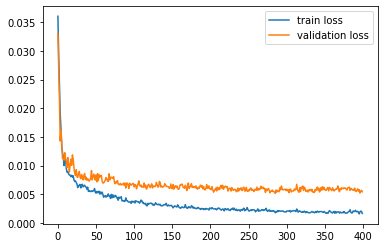

In [26]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(n_epochs),train_losses,label='train loss')
plt.plot(torch.arange(n_epochs),val_losses,label='validation loss')
plt.legend()
